### Определение темы по постам группы вк

Будем собирать посты из группы "Лентач" во вконтакте с целью выявить тематику группы. Рассмотрим также на какие кластеры тем можно разбить посты.

In [2]:
import logging
import sys
import requests
import json
import datetime
from ast import literal_eval
import pandas as pd
import numpy as np
import configparser
import re
import nltk
from nltk.corpus import stopwords 
# from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
# lemma = WordNetLemmatizer()

import pymorphy2
morph = pymorphy2.MorphAnalyzer()

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package wordnet to /Users/mary/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/mary/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/mary/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


### 1. Сбор информации. 



In [3]:
def gather_process():

    # gather data and save as txt
    id_ = 'lentach'
    owner_id = '29534144'# lentach
    count = 40
    offset = -1

    # In access_token.ini we have token for vk
    config = configparser.ConfigParser()
    config.read('access_token.ini')
    access_token = config.get('settings', 'token')
    
    for _ in range(100):
        url = 'https://api.vk.com/method/wall.get?owner_id=-{}&count={}&offset={}&v=5.52&access_token={}'.format(
            owner_id, count, offset + 1, access_token)
        respond = requests.get(url)
        with open(id_ + str(_) + '.txt', 'w') as outfile:
            json.dump(respond.json(), outfile)
        
        offset += count

In [4]:
def convert_data_to_table_format():
    
    # transform gathered data from txt file to pandas DataFrame and save as csv
    id_ = 'lentach'
    
    for _ in range(40):
        file = id_ + str(_) + '.txt'
        result = literal_eval(open(file, 'r').read())
        ids = []
        dates = []
        comments = []
        likes = []
        reposts = []
        text = []

        for item in result['response']['items']:
            ids.append(item['id'])
            dates.append(datetime.datetime.fromtimestamp(item['date']))
            comments.append(item['comments']['count'])
            likes.append(item['likes']['count'])
            reposts.append(item['reposts']['count'])
            text.append(item['text'].encode('utf-16', 'surrogatepass').decode('utf-16'))

        df = pd.DataFrame({
            "id": ids,
            "date": dates,
            "comments_count": comments,
            "likes_count": likes,
            "reposts_count": reposts,
            "text": text,
        })
        df.to_csv(id_ + str(_) + '.csv', sep='\t')
    
    pass



In [5]:
# Take latest 4 000 posts of lentach
# gather_process()

In [35]:
# Convert to csv
convert_data_to_table_format()

In [36]:
# Create 1 df from 40 files
df = pd.concat([pd.read_csv(r'lentach' + str(i) + '.csv', sep='\t') for i in range(40)], axis=0)
df.shape

(4000, 7)

In [37]:
df[98:103]

,Unnamed: 0,id,date,comments_count,likes_count,reposts_count,text
98,98,11435352,2019-07-02 12:35:12,133,2793,11,Чехия сняла ограничения на полёты российских а...
99,99,11434988,2019-07-02 11:35:06,198,8598,204,В декабре 2018 года студент ВГИКа Артём Фирсан...
0,0,11434891,2019-07-02 11:20:00,43,373,6,• «Интерфакс»: число жертв паводка в Иркутской...
1,1,11434549,2019-07-02 10:36:15,199,5763,78,"Цены на свинину, говядину и мясо птицы в Росси..."
2,2,11434254,2019-07-02 09:34:23,288,1718,15,Сегодня утром власти Чехии запретили «Аэрофлот...


In [38]:
df = df.set_index('id')
df = df.drop(['Unnamed: 0'], axis=1)

In [39]:
df.head()

,date,comments_count,likes_count,reposts_count,text
id,,,,,
11460130,2019-07-06 16:13:03,92,1146,15,Список «ремейки фильмов с женщинами в главной ...
11459911,2019-07-06 15:33:47,155,1803,31,В России планируется своя «Википедия».\n\nПрав...
11459474,2019-07-06 14:17:03,168,6437,231,"А вы тоже в детстве двигали мышкой по экрану, ..."
11459119,2019-07-06 13:23:59,130,4821,141,Уже десять лет каждую первую субботу июля росс...
11458585,2019-07-06 12:11:06,681,5606,81,Основатель Amazon Джефф Безос официально развё...


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 11460130 to 10386610
Data columns (total 5 columns):
date              4000 non-null object
comments_count    4000 non-null int64
likes_count       4000 non-null int64
reposts_count     4000 non-null int64
text              3864 non-null object
dtypes: int64(3), object(2)
memory usage: 187.5+ KB


### 2. Обработка. 

* Удалим пропуски в значениях текста, т.к. никакая их обработка не поможет нашей цели
* Удалим русские стоп слова и знаки переноса строки (очистим текст)
* Разобьем каждый из текстов на отдельные слова
* Приведем слова к нормальной форме


In [84]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3864 entries, 11460130 to 10386610
Data columns (total 5 columns):
date              3864 non-null object
comments_count    3864 non-null int64
likes_count       3864 non-null int64
reposts_count     3864 non-null int64
text              3864 non-null object
dtypes: int64(3), object(2)
memory usage: 181.1+ KB


In [85]:
stop_words = stopwords.words('russian')
stop_words.extend(['http', 'https', 'lenta', 'ch', 'cc', 'ow', 'news', 'vk', 'upd', 'the', 'id', 'который', 'это'])
stop_words = set(stop_words)

In [86]:
def clean(text):
    # Remove garbage from lines
    text = re.sub(r'\n', ' ', text, flags=re.IGNORECASE)
    text = re.sub(r'•', '', text, flags=re.IGNORECASE)
    return text


def doc_to_words(doc, stop_words, morph):
    # remove stop words and punctuation
    words = [w for w in gensim.utils.simple_preprocess(str(doc), deacc=True) if w not in stop_words]
    
    # make lemmatization
    words = [morph.parse(w)[0].normal_form for w in words]
    
    return words

In [87]:
# Clean and split by words

data = df.text.values.tolist()
data = [clean(t) for t in data]
data_words = [doc_to_words(row, stop_words, morph) for row in data]

In [88]:
print(data[0])
print(data_words[0])

Список «ремейки фильмов с женщинами в главной роли» может пополниться ещё одной картиной.  На этот раз в лучших традициях последних лет планируют переснять ту самую «Маску» с Джимом Кэрри  http://news.lenta.ch/Ow21
['список', 'ремеик', 'фильм', 'женщина', 'главной', 'роль', 'пополниться', 'одной', 'картиной', 'хороший', 'традиция', 'последний', 'год', 'планировать', 'переснять', 'тот', 'самый', 'маска', 'джим', 'кэрри']


### 3. Построение моделей

* Найдем биграммы слов в каждом тексте
* Занумеруем биграммы (добавив им id) и посчитаем сколько раз то или иное слово встречалось внутри каждого текста (сделаем корпус)
* Попробуем разбить тексты на несколько тематик: построим зависимость когерентности от количества тематик; оптимальное число отобразим
* 

In [89]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=1, delimiter=b' ') # higher threshold fewer phrases.

bigram_mod = gensim.models.phrases.Phraser(bigram)    
data_words_bigrams = [bigram_mod[w] for w in data_words]

In [90]:
data_words_bigrams[:3]

[['список',
  'ремеик',
  'фильм',
  'женщина',
  'главной',
  'роль',
  'пополниться',
  'одной',
  'картиной',
  'хороший',
  'традиция',
  'последний год',
  'планировать',
  'переснять',
  'тот',
  'самый',
  'маска',
  'джим',
  'кэрри'],
 ['россия',
  'планироваться',
  'свой',
  'википедия',
  'правительство',
  'разработать',
  'законопроект',
  'выделяющие',
  'деньга',
  'бюджет'],
 ['детство',
  'двигать',
  'мышкой',
  'экран',
  'пока',
  'загружаться',
  'устанавливаться',
  'мол',
  'комп',
  'быстрый',
  'работать',
  'правый',
  'недавно',
  'выясниться',
  'windows',
  'система',
  'многозадачность',
  'выполнять',
  'задача',
  'ввод',
  'вывод',
  'движение',
  'мышка',
  'печать',
  'клавиатура',
  'сразу',
  'фоновый',
  'задача',
  'одной',
  'той',
  'скорость',
  'система',
  'работать',
  'циклично',
  'дожидаться',
  'буфер',
  'набраться',
  'нужный',
  'количество',
  'задача',
  'затем',
  'выполнять',
  'цикл',
  'повторяться',
  'получаться',
  'запуск',

In [91]:
id2word = corpora.Dictionary(data_words_bigrams) # token to id (add ids to tokens)
corpus = [id2word.doc2bow(text) for text in data_words_bigrams] # create (token_id, token_count): 2-tuples

In [92]:
print(corpus[2])
print(id2word[84])

[(6, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 2), (36, 1), (37, 2), (38, 2), (39, 1), (40, 1), (41, 2), (42, 2), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 2), (50, 5), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 2), (65, 2), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 3), (81, 1), (82, 2), (83, 1), (84, 1), (85, 1), (86, 1), (87, 2), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 3), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1)]
совершать


In [93]:
data[2].count('система')

2

In [94]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics, 
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [95]:
limit=25; start=2; step=6;
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_words_bigrams, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

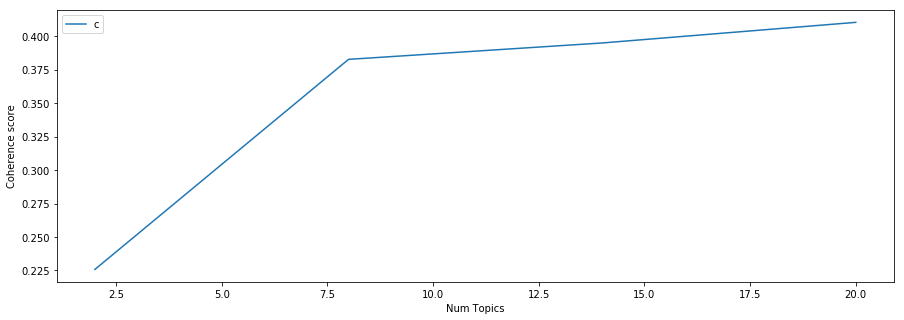

In [96]:
x = range(start, limit, step)
plt.figure(figsize=(15,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Судя по графику, оптимальным числом будет 8 тем - единственный локоть. Попробуем такое разбиение

In [97]:
lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=8, 
        random_state=100,
        update_every=1,
        chunksize=500,
        passes=50,
        alpha='auto');


In [98]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/mary/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.365385  0.012317       1        1  37.076828
7     -0.031460 -0.240071       2        1  14.520186
0     -0.006676  0.245034       3        1  13.430570
5      0.100254 -0.015381       4        1   9.395811
2      0.086706 -0.004858       5        1   8.632192
3      0.064568 -0.020411       6        1   6.793750
6      0.080414  0.021716       7        1   6.128387
1      0.071580  0.001653       8        1   4.022282, topic_info=     Category        Freq                      Term       Total  loglift  \
term                                                                       
251   Default  451.000000                   который  451.000000  30.0000   
210   Default  395.000000                   это час  395.000000  29.0000   
191   Default  392.000000            другой новость  392.000000  28.0000   
232   Default  241.000000                   человек  241.000000  27.0000   
27    Default  331.000000                    россия  331.000000  26.0000   
1659  Default  102.000000                    рублей  102.000000  25.0000   
552   Default  101.000000                    группа  101.000000  24.0000   
189   Default   78.000000  традиционный радиолентач   78.000000  23.0000   
17    Default   87.000000                     фильм   87.000000  22.0000   
28    Default  244.000000                      свой  244.000000  21.0000   
735   Default   71.000000                   самолёт   71.000000  20.0000   
473   Default  169.000000                     город  169.000000  19.0000   
642   Default  165.000000                   заявить  165.000000  18.0000   
1745  Default   70.000000                     место   70.000000  17.0000   
110   Default  170.000000                      один  170.000000  16.0000   
36    Default  200.000000                     время  200.000000  15.0000   
103   Default  389.000000                       год  389.000000  14.0000   
640   Default   74.000000                       дом   74.000000  13.0000   
263   Default  151.000000                       сша  151.000000  12.0000   
218   Default  172.000000                    москва  172.000000  11.0000   
243   Default  149.000000                     стать  149.000000  10.0000   
1106  Default  141.000000                    власть  141.000000   9.0000   
114   Default  123.000000                 россиянин  123.000000   8.0000   
18    Default   59.000000                   хороший   59.000000   7.0000   
273   Default  128.000000                      дело  128.000000   6.0000   
608   Default   85.000000                  интернет   85.000000   5.0000   
366   Default  114.000000                     такой  114.000000   4.0000   
23    Default   55.000000              законопроект   55.000000   3.0000   
1938  Default  116.000000                     школа  116.000000   2.0000   
929   Default   64.000000                    лентач   64.000000   1.0000   
...       ...         ...                       ...         ...      ...   
2169   Topic8   12.509966                обратиться   13.203934   3.1593   
10     Topic8   11.940681             последний год   12.633735   3.1569   
6521   Topic8   11.824175                 мобильный   12.517262   3.1564   
6341   Topic8   11.837156                устроиство   12.531221   3.1563   
2175   Topic8   11.493001               шереметьево   12.186822   3.1547   
6376   Topic8   11.333724                   закрыть   12.027082   3.1539   
1676   Topic8   10.920385                    кредит   11.613959   3.1517   
2082   Topic8    9.969928                    убрать   10.663114   3.1461   
69     Topic8    9.776036                    нужный   10.469559   3.1448   
1156   Topic8    9.465165                      путь   10.158880   3.1426   
1443   Topic8    9.193713              национальный    9.887261   3.1406   
3206   Topic8    9.063761             исследователь    9.757017   3.1396 

In [99]:
pprint(lda_model.print_topics())

[(0,
  '0.009*"фильм" + 0.006*"хороший" + 0.006*"интернет" + 0.005*"законопроект" + '
  '0.005*"россиянин" + 0.004*"житель" + 0.004*"россия" + 0.004*"лучшие" + '
  '0.004*"новыя" + 0.004*"концерт"'),
 (1,
  '0.005*"завод" + 0.005*"личный" + 0.004*"вернуть" + 0.004*"добавить" + '
  '0.004*"попытаться" + 0.004*"обратиться" + 0.004*"последний год" + '
  '0.004*"устроиство" + 0.004*"мобильный" + 0.004*"шереметьево"'),
 (2,
  '0.005*"граница" + 0.004*"пока" + 0.004*"отменить" + 0.004*"актёр" + '
  '0.004*"делать" + 0.003*"больница" + 0.003*"отправить" + 0.003*"погибнуть '
  'человек" + 0.003*"житель" + 0.003*"безопасность"'),
 (3,
  '0.006*"администрация" + 0.005*"club" + 0.004*"apple" + 0.004*"лентач" + '
  '0.004*"пост" + 0.004*"мнение" + 0.003*"образ" + 0.003*"билет" + '
  '0.003*"пройти" + 0.003*"важный"'),
 (4,
  '0.013*"который" + 0.013*"это час" + 0.013*"другой новость" + 0.012*"год" + '
  '0.010*"россия" + 0.009*"человек" + 0.007*"время" + 0.007*"свой" + '
  '0.006*"один" + 0.006*"г

In [100]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.334742566811663

Coherence Score:  0.4509353998341119


Визуально действительно получились неплохие группы. Попробуем теперь описать тематику всего сообщества в целом

In [102]:
lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=1, 
        random_state=100,
        update_every=1,
        chunksize=500,
        passes=50,
        alpha='auto');

In [103]:
pprint(lda_model.print_topics())

[(0,
  '0.005*"который" + 0.005*"год" + 0.005*"это час" + 0.005*"другой новость" + '
  '0.004*"россия" + 0.003*"свой" + 0.003*"человек" + 0.002*"время" + '
  '0.002*"москва" + 0.002*"один"')]


Получили похожий на правду результат: Лентач - новостной аггрегатор, рассказывающий о России и о том, как люди в ней живут